## The VGG16 model development and fine tuning

in this notebook we will load and add our layers to the base model of the pre-trained VGG16 model, and fine tune the following components of the model:
1. **Optimizers** - We will use only 5 optimizers to see which one works best, namely; 1. `SGD`,2. `RMSprop`,3. `Adam`,4. `Adagrad`,5. `Adadelta`. the best optimizer will be used in the New model
2. **Number of epochs** - We will also use only 4 epochs to choose the best performer namely; `1, 2, 5, 10`.
3. **Batch size** - we will also use these batch sizes to choose the optimum batch size, namely; `8, 16`. 
4. **Dropout value** - we will then use these dropout values to choose the optimum dropout value, namely; `0.5, 0.6, 0.7, 0.8, 0.9`

> **Section one:** we will create common function and also create our base model, with the following initial parameters: **Batch size** `8`, **Optimizer** `Adam`, **Number of epochs** `5`, 

# **Import libraries that we will use**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Final_BRH35_Dataset.zip' -d '/content/Final_BRH35_Datasets'

Streaming output truncated to the last 5000 lines.
  inflating: /content/Final_BRH35_Datasets/Training/Pituitary_Tumor/Tr-pi_0163.jpg  
  inflating: /content/Final_BRH35_Datasets/Training/Pituitary_Tumor/Tr-pi_0164.jpg  
  inflating: /content/Final_BRH35_Datasets/Training/Pituitary_Tumor/Tr-pi_0165.jpg  
  inflating: /content/Final_BRH35_Datasets/Training/Pituitary_Tumor/Tr-pi_0166.jpg  
  inflating: /content/Final_BRH35_Datasets/Training/Pituitary_Tumor/Tr-pi_0167.jpg  
  inflating: /content/Final_BRH35_Datasets/Training/Pituitary_Tumor/Tr-pi_0168.jpg  
  inflating: /content/Final_BRH35_Datasets/Training/Pituitary_Tumor/Tr-pi_0169.jpg  
  inflating: /content/Final_BRH35_Datasets/Training/Pituitary_Tumor/Tr-pi_0170.jpg  
  inflating: /content/Final_BRH35_Datasets/Training/Pituitary_Tumor/Tr-pi_0171.jpg  
  inflating: /content/Final_BRH35_Datasets/Training/Pituitary_Tumor/Tr-pi_0172.jpg  
  inflating: /content/Final_BRH35_Datasets/Training/Pituitary_Tumor/Tr-pi_0173.jpg  
  inflating: /

In [ ]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import keras
import cv2
import random
import PIL
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.applications.vgg16 import preprocess_input 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Input
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_notebook
import time
import tqdm.gui as tqdm
import tqdm.notebook as tqdm

In [ ]:
ROOT_DIR = "Final_BRH35_Datasets"

# List the number of images in each class
number_of_images = {}
for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))
print(number_of_images)

{'Validation': 4, 'Training': 4, 'Testing': 4}


# **Common functions**

In [ ]:
def get_data_generator(train_data_path, \
                       val_data_path, \
                       targetsize, \
                       classmode, \
                       batchsize):
    """
    This function is a data generator function for train, validation
    Inputs
        train_data_path   : train data path for the dataset 
        val_data_path     : validation data path for the dataset
        targetsize        : target size for the generator to resize all images to, (224,224)
        classmode         : class mode, 'categorical'
        batchsize         : batch size
    Outputs
        train_generator   : generated train data
        val_generator   : generated train data
    
    """
    train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    
    train_generator=train_datagen.flow_from_directory(train_data_path, # this is where you specify the path to the main data folder
                                                 target_size=targetsize,
                                                 color_mode='rgb',
                                                 batch_size=batchsize,
                                                 class_mode=classmode,
                                                 shuffle=True)
    
    val_generator=val_datagen.flow_from_directory(val_data_path, # this is where you specify the path to the main data folder
                                                 target_size=targetsize,
                                                 color_mode='rgb',
                                                 batch_size=batchsize,
                                                 class_mode=classmode,
                                                 shuffle=True)
    return train_generator,val_generator   

In [ ]:
def train_evaluate_the_model(train_generator, \
                            val_generator, \
                            optimizer, \
                            epochs, \
                            dropout_value, \
                            TheModel):
    '''
    train the model, do predictions, and do evaluation and return the accuracy of the model
    Inputs
        train_generator : generated train data
        val_generator   : generated validation data
        optimizer       : the optimizer method used to compile the model
        epochs          : the epochs of the model use to fit the model
        TheModel        : The pretrained model loaded,
    Outputs
        accuracy        : The accuracy of the model
    '''
    # load pretrained model and add layers on top of the model
    x = TheModel.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024,activation='relu')(x)
    x = Dense(1024,activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_value)(x)
    preds = Dense(4,activation='softmax')(x)
    model = Model(inputs = TheModel.input,outputs=preds)
    
    # freeze base layers for training
    for layer in TheModel.layers:
        layer.trainable = False
    
    # compile the model
    model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    step_size_train=train_generator.n//train_generator.batch_size
    # fit the model
    r = model.fit_generator(generator=train_generator,
                        validation_data=val_generator,
                        steps_per_epoch=step_size_train,
                        epochs=epochs)
    # valuate the model
    scores = model.evaluate(val_generator)
    accuracy = scores[1]*100
    
    return accuracy, model

## **Explore the preprocess_input function**

## The preprocess_input function will be used to preprocess the images so that they can be ready to be fed into the models.

In [ ]:
directory = '/content/Final_BRH35_Datasets/Training/Glioma_Tumor'
imgs = []

for filename in os.listdir(directory):
    img_path = os.path.join(directory, filename)
    img = load_img(img_path)
    imgs.append(img)

In [ ]:
z=random.randint(1,len(imgs))
im = img_to_array(imgs[z])
print("Maximum pixel value before preprocessing: ",im.max())

Maximum pixel value before preprocessing:  255.0


In [ ]:
im = preprocess_input(im)
print("Maxium pixel value after pre-processing :",im.max())

Maxium pixel value after pre-processing : 151.061


Text(0.5, 1.0, 'Preprocessed Image')

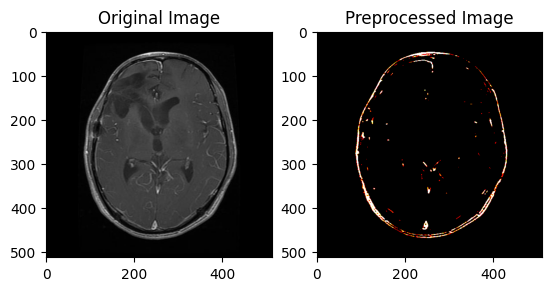

In [ ]:
z=random.randint(1,len(imgs))
im = img_to_array(imgs[z])
im = np.expand_dims(im, axis=0)
im = preprocess_input(im)

plt.subplot(1,2,1)
plt.imshow(imgs[z])
plt.title("Original Image")
        
        
plt.subplot(1,2,2)
im=np.reshape(im,(im.shape[1],im.shape[2],im.shape[3]))
plt.imshow(im)
plt.title("Preprocessed Image")

# **Load and generate data**

In [ ]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

'''
Initial and constant parameters for the model
initial parameters
       batch_size    : the initial batch size we will create our base model with
Constant parameters
       target_size   : Constant image target size for the whole notebook which is (224,224)
       class_mode    : class mode we will use for the whole notebook, which is 'categorical'
'''
# constant parameters
targetsize_constant = (224,224)
classmode_constant = 'categorical'

# initial parameters
batchsize_initial = 8
epochs_initial = 4
dropout_value_initial = 0.5
optimizer_initial = 'Adam'

# Data paths
train_dataset_path = 'Final_BRH35_Datasets/Training/'
test_dataset_path = 'Final_BRH35_Datasets/Testing'
validation_dataset_path = 'Final_BRH35_Datasets/Validation/'



train_generator_initial = train_datagen.flow_from_directory(train_dataset_path, # this is where you specify the path to the main data folder
                                                 target_size=targetsize_constant,
                                                 color_mode='rgb',
                                                 batch_size=batchsize_initial,
                                                 class_mode=classmode_constant,
                                                 shuffle=True)
val_generator_initial = val_datagen.flow_from_directory(validation_dataset_path, # this is where you specify the path to the main data folder
                                                 target_size=targetsize_constant,
                                                 color_mode='rgb',
                                                 batch_size=batchsize_initial,
                                                 class_mode=classmode_constant,
                                                 shuffle=True)


Found 8582 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [ ]:
# display classes found in the data
train_generator_initial.class_indices

{'Glioma_Tumor': 0,
 'Meningioma_Tumor': 1,
 'Pituitary_Tumor': 2,
 'Tumor_Free_Images': 3}

#### Import the VGG16 base model

In [ ]:
image_size = [224,224] # choose image size
# import the base model
vgg = VGG16(input_shape= image_size+[3],weights='imagenet',include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


# **Add layers on top of the base model**

In [ ]:
x = vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512, activation='relu')(x)
preds = Dense(4,activation='softmax')(x)
model = Model(inputs = vgg.input,outputs=preds)

In [ ]:
# freeze base layers for training
for layer in vgg.layers:
    layer.trainable = False

# **Compile the model**

In [ ]:
# initial optimizer
optimizer_initial = 'Adam'

# compile the model
model.compile(optimizer=optimizer_initial,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# **Fit the model**

In [ ]:
# initial parameters
epochs_initial = 5
step_size_train_initial=train_generator_initial.n//train_generator_initial.batch_size # computing the steps size per epoch

tic = time.time()
# fit the model
r = model.fit_generator(generator=train_generator_initial,
                        validation_data=val_generator_initial,
                        steps_per_epoch=step_size_train_initial,
                        epochs=epochs_initial)

toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))

Epoch 1/5


<ipython-input-24-db1a9d6bad61>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(generator=train_generator_initial,


1072/1072 [==============================] - 303s 281ms/step - loss: 0.4386 - accuracy: 0.8501 - val_loss: 1.2085 - val_accuracy: 0.6980
Epoch 2/5
1072/1072 [==============================] - 298s 278ms/step - loss: 0.2327 - accuracy: 0.9185 - val_loss: 1.6082 - val_accuracy: 0.7081
Epoch 3/5
1072/1072 [==============================] - 303s 283ms/step - loss: 0.1636 - accuracy: 0.9381 - val_loss: 1.5442 - val_accuracy: 0.7690
Epoch 4/5
1072/1072 [==============================] - 296s 276ms/step - loss: 0.1394 - accuracy: 0.9498 - val_loss: 1.7398 - val_accuracy: 0.7437
Epoch 5/5
1072/1072 [==============================] - 306s 285ms/step - loss: 0.1166 - accuracy: 0.9634 - val_loss: 2.5008 - val_accuracy: 0.7259
Minutes taken = 25.535023335615794


# **Evaluate the model**

In [ ]:
# evaluation on validation data
scores = model.evaluate(val_generator_initial)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

#scores = model.evaluate_generator(val_generator)
#print("%s%s: %.2f%%" % ("evaluate_generator ",model.metrics_names[1], scores[1]*100))

50/50 [==============================] - 14s 284ms/step - loss: 2.5008 - accuracy: 0.7259
evaluate accuracy: 72.59%


# **Section two:** We will start fine tunning
## **Tunning optimizers of the model**

In [ ]:
TheBaseModel = VGG16(input_shape= image_size+[3],weights='imagenet',include_top=False) # load a clean base model

param_label = 'optimizer'
param_list = ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'Adadelta'] # ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'Adadelta']

accuracy_table = {param_label: [], 'accuracy': []}
tic = time.time()
for param in tqdm.tqdm_notebook(param_list):
    # Train, predict and evaluate model
    accuracy, _ = train_evaluate_the_model(train_generator_initial, val_generator_initial, param, epochs_initial, dropout_value_initial, TheBaseModel)
    
    # Collect results
    accuracy_table[param_label].append(param)
    accuracy_table['accuracy'].append(accuracy)
    
accuracy_table = pd.DataFrame(accuracy_table) # convert the table to a dataframe
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
accuracy_table # display the results

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


<ipython-input-27-4701248b849b>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(generator=train_generator,


1072/1072 [==============================] - 312s 290ms/step - loss: 0.4822 - accuracy: 0.8401 - val_loss: 1.5943 - val_accuracy: 0.6751
Epoch 2/5
1072/1072 [==============================] - 295s 275ms/step - loss: 0.2614 - accuracy: 0.9109 - val_loss: 2.9592 - val_accuracy: 0.6269
Epoch 3/5
1072/1072 [==============================] - 298s 278ms/step - loss: 0.1950 - accuracy: 0.9327 - val_loss: 1.8569 - val_accuracy: 0.6878
Epoch 4/5
1072/1072 [==============================] - 299s 279ms/step - loss: 0.1632 - accuracy: 0.9443 - val_loss: 1.2382 - val_accuracy: 0.7843
Epoch 5/5
50/50 [==============================] - 14s 273ms/step - loss: 2.5788 - accuracy: 0.7563
Epoch 1/5
1072/1072 [==============================] - 310s 289ms/step - loss: 0.4909 - accuracy: 0.8178 - val_loss: 1.1812 - val_accuracy: 0.6929
Epoch 2/5
1072/1072 [==============================] - 295s 275ms/step - loss: 0.2315 - accuracy: 0.9114 - val_loss: 1.4238 - val_accuracy: 0.7513
Epoch 3/5
1072/1072 [=======

,optimizer,accuracy
0,Adam,75.634515
1,SGD,77.664977
2,RMSprop,70.558375
3,Adagrad,78.426397
4,Adadelta,48.984772


Text(0, 0.5, 'accuracy)')

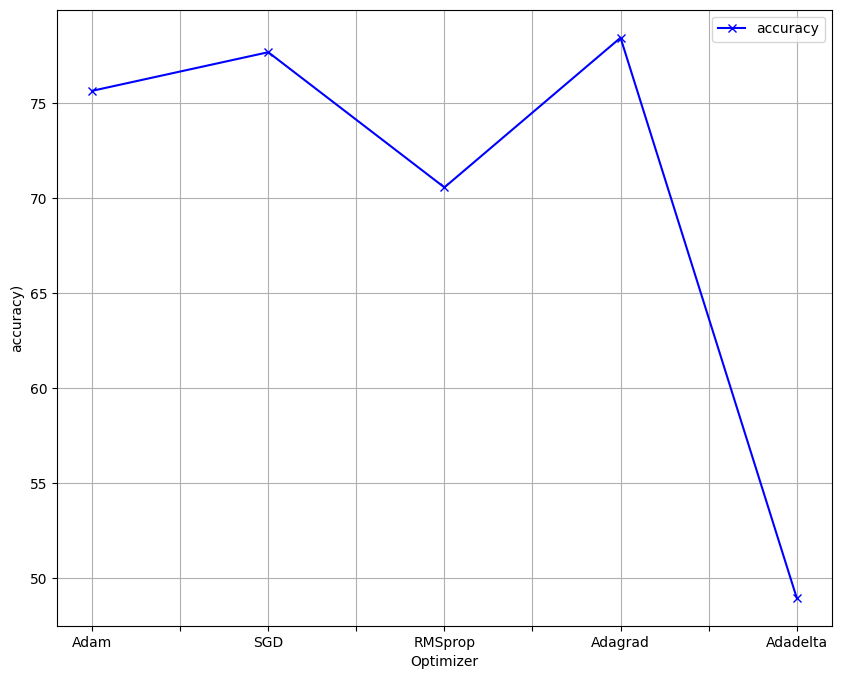

In [ ]:
from pylab import rcParams

# plot results
rcParams['figure.figsize'] = 10,8 # width 10, height 8

ax = accuracy_table.plot(x='optimizer', y='accuracy',style='bx-', grid=True)
#ax.set_xticklabels(param_list) # gave me an error when used
ax.set_xlabel("Optimizer")
ax.set_ylabel("accuracy)")

In [ ]:
# Get optimum value for param
temp = accuracy_table[accuracy_table['accuracy'] == accuracy_table['accuracy'].max()]
optimizer_opt = temp[param_label].values[0]
print("max Accuracy = %0.3f" % accuracy_table['accuracy'].max())
print("optimum " + param_label + " = " + str(optimizer_opt))

max Accuracy = 78.426
optimum optimizer = Adagrad


# **Tuning batch size and epochs of the model**

In [ ]:
TheBaseModel = VGG16(input_shape= image_size+[3],weights='imagenet',include_top=False) # load a clean base model

param_label = 'epochs'
param_list = [1,2,5,10] # [5, 10, 15, 20]

param2_label = 'batch_size'
param2_list = [8, 16] # [8, 16, 32] am using this batch sizes for now until we fix the accuracy issue, proper batch sizes to be use [8, 16, 32, 64, 128]

accuracy_table = {param_label: [], param2_label: [], 'accuracy': []}
tic = time.time()
for param in tqdm.tqdm_notebook(param_list):
    for param2 in tqdm_notebook(param2_list):
        # generate train and validation data
        train_generator, val_generator = get_data_generator(train_dataset_path, validation_dataset_path, targetsize_constant, classmode_constant, param2)
        # train, predict and evaluate model
        accuracy, _ = train_evaluate_the_model(train_generator, val_generator, optimizer_initial, param, dropout_value_initial ,TheBaseModel)
        
        # collect results
        accuracy_table[param_label].append(param)
        accuracy_table[param2_label].append(param2)
        accuracy_table['accuracy'].append(accuracy)
        
accuracy_table = pd.DataFrame(accuracy_table) # convert the table to a dataframe
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
accuracy_table # display the resullts

  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-53-4a220837399b>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param2 in tqdm_notebook(param2_list):


  0%|          | 0/2 [00:00<?, ?it/s]

Found 8582 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


<ipython-input-27-4701248b849b>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(generator=train_generator,


50/50 [==============================] - 13s 254ms/step - loss: 1.2058 - accuracy: 0.6168
Found 8582 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
25/25 [==============================] - 13s 512ms/step - loss: 1.4608 - accuracy: 0.6472


  0%|          | 0/2 [00:00<?, ?it/s]

Found 8582 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/2
1072/1072 [==============================] - 305s 283ms/step - loss: 0.5015 - accuracy: 0.8359 - val_loss: 2.9620 - val_accuracy: 0.5457
Epoch 2/2
50/50 [==============================] - 13s 255ms/step - loss: 1.3172 - accuracy: 0.6624
Found 8582 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/2
536/536 [==============================] - 295s 548ms/step - loss: 0.4927 - accuracy: 0.8349 - val_loss: 1.0324 - val_accuracy: 0.6904
Epoch 2/2
25/25 [==============================] - 13s 495ms/step - loss: 1.7878 - accuracy: 0.6701


  0%|          | 0/2 [00:00<?, ?it/s]

Found 8582 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/5
1072/1072 [==============================] - 294s 274ms/step - loss: 0.5017 - accuracy: 0.8322 - val_loss: 1.4923 - val_accuracy: 0.6701
Epoch 2/5
1072/1072 [==============================] - 299s 279ms/step - loss: 0.2561 - accuracy: 0.9075 - val_loss: 2.7167 - val_accuracy: 0.6015
Epoch 3/5
1072/1072 [==============================] - 302s 282ms/step - loss: 0.2136 - accuracy: 0.9275 - val_loss: 1.4457 - val_accuracy: 0.7437
Epoch 4/5
1072/1072 [==============================] - 297s 277ms/step - loss: 0.1502 - accuracy: 0.9496 - val_loss: 1.3876 - val_accuracy: 0.7411
Epoch 5/5
50/50 [==============================] - 13s 253ms/step - loss: 1.1320 - accuracy: 0.7513
Found 8582 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/5
536/536 [==============================] - 287s 534ms/step - loss: 0.4820 - accuracy: 0.8385 - val_loss: 1.4966 - val_accuracy: 0.6574
E

  0%|          | 0/2 [00:00<?, ?it/s]

Found 8582 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/10
1072/1072 [==============================] - 318s 295ms/step - loss: 0.4887 - accuracy: 0.8326 - val_loss: 0.8912 - val_accuracy: 0.7259
Epoch 2/10
1072/1072 [==============================] - 311s 290ms/step - loss: 0.2451 - accuracy: 0.9124 - val_loss: 2.3004 - val_accuracy: 0.6726
Epoch 3/10
1072/1072 [==============================] - 290s 271ms/step - loss: 0.1826 - accuracy: 0.9345 - val_loss: 2.4648 - val_accuracy: 0.6904
Epoch 4/10
1072/1072 [==============================] - 290s 271ms/step - loss: 0.1528 - accuracy: 0.9460 - val_loss: 1.5373 - val_accuracy: 0.7005
Epoch 5/10
1072/1072 [==============================] - 291s 271ms/step - loss: 0.1128 - accuracy: 0.9606 - val_loss: 2.7676 - val_accuracy: 0.7538
Epoch 6/10
1072/1072 [==============================] - 292s 273ms/step - loss: 0.1310 - accuracy: 0.9596 - val_loss: 1.7632 - val_accuracy: 0.7919
Epoch 7/10
1072/1072 [=======

,epochs,batch_size,accuracy
0,1,8,61.675125
1,1,16,64.720809
2,2,8,66.243654
3,2,16,67.005074
4,5,8,75.126904
5,5,16,76.395941
6,10,8,74.873096
7,10,16,80.710661


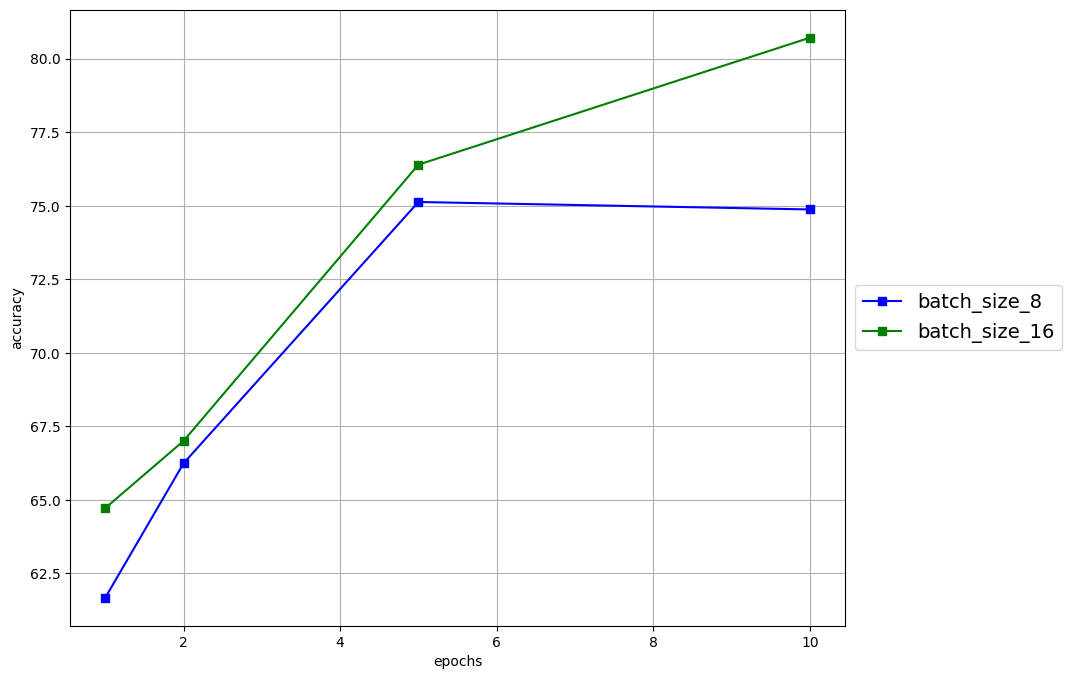

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = accuracy_table[accuracy_table[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='accuracy', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', '0.75']
for i in range(1,len(param2_list)):
    temp = accuracy_table[accuracy_table[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='accuracy', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("accuracy")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure


In [ ]:
# Get optimum value for param and param2
temp = accuracy_table[accuracy_table['accuracy'] == accuracy_table['accuracy'].max()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("max Accuracy = %0.3f" % accuracy_table['accuracy'].max())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

max Accuracy = 80.711
optimum epochs = 10
optimum batch_size = 16


# **Tunning dropout of the model**

In [ ]:
param_label = 'dropout_prob'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9]

TheBaseModel = VGG16(input_shape= image_size+[3],weights='imagenet',include_top=False) # load a clean base model

accuracy_table = {param_label: [], 'accuracy': []}
tic = time.time()
for param in tqdm.tqdm_notebook(param_list):
    # Train, predict and evaluate model
    accuracy, _ = train_evaluate_the_model(train_generator_initial,val_generator_initial,optimizer_initial,epochs_initial,param,TheBaseModel) # replace epochs with 'epochs_initial'
    
    # Collect results
    accuracy_table[param_label].append(param)
    accuracy_table['accuracy'].append(accuracy)
    
accuracy_table = pd.DataFrame(accuracy_table) # convert the table to a dataframe
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
accuracy_table # display the resullts

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/4


<ipython-input-27-4701248b849b>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(generator=train_generator,


1072/1072 [==============================] - 335s 311ms/step - loss: 0.4964 - accuracy: 0.8311 - val_loss: 1.1532 - val_accuracy: 0.6574
Epoch 2/4
1072/1072 [==============================] - 293s 274ms/step - loss: 0.2542 - accuracy: 0.9095 - val_loss: 1.6503 - val_accuracy: 0.7081
Epoch 3/4
1072/1072 [==============================] - 293s 273ms/step - loss: 0.2050 - accuracy: 0.9286 - val_loss: 1.4147 - val_accuracy: 0.7183
Epoch 4/4
50/50 [==============================] - 13s 255ms/step - loss: 1.5077 - accuracy: 0.7640
Epoch 1/4
1072/1072 [==============================] - 295s 274ms/step - loss: 0.5198 - accuracy: 0.8305 - val_loss: 1.3727 - val_accuracy: 0.6142
Epoch 2/4
1072/1072 [==============================] - 295s 276ms/step - loss: 0.2591 - accuracy: 0.9028 - val_loss: 1.4459 - val_accuracy: 0.6802
Epoch 3/4
1072/1072 [==============================] - 292s 273ms/step - loss: 0.2126 - accuracy: 0.9287 - val_loss: 1.8660 - val_accuracy: 0.7360
Epoch 4/4
50/50 [===========

,dropout_prob,accuracy
0,0.5,76.395941
1,0.6,72.081220
2,0.7,75.888324
3,0.8,75.888324
4,0.9,74.365485


Text(0, 0.5, 'accuracy)')

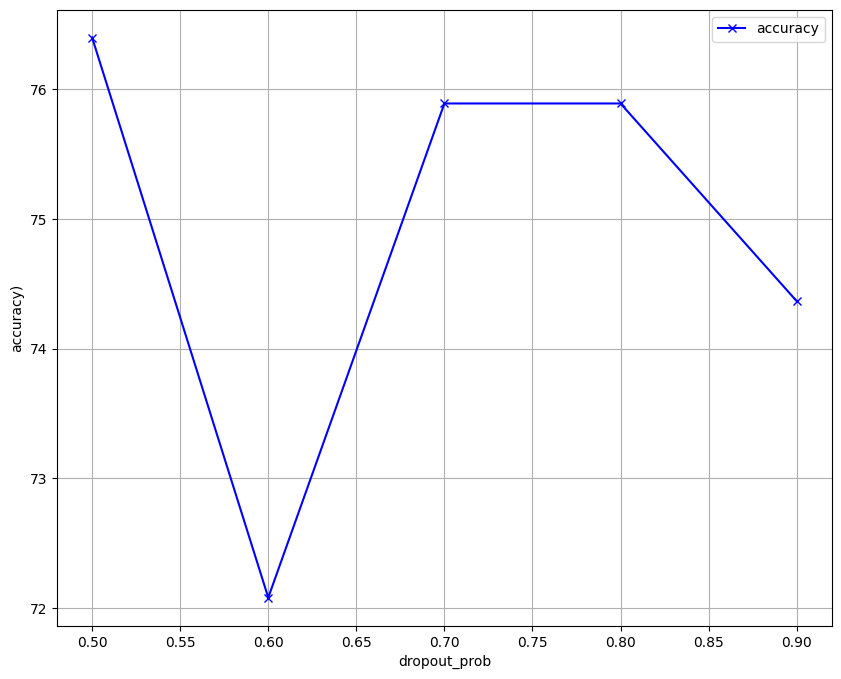

In [ ]:
from pylab import rcParams

# plot results
rcParams['figure.figsize'] = 10,8 # width 10, height 8

ax = accuracy_table.plot(x='dropout_prob', y='accuracy',style='bx-', grid=True)
#ax.set_xticklabels(param_list) # gave me an error when used
ax.set_xlabel("dropout_prob")
ax.set_ylabel("accuracy)")

In [ ]:
# Get optimum value for param
temp = accuracy_table[accuracy_table['accuracy'] == accuracy_table['accuracy'].max()]
dropout_opt = temp[param_label].values[0]
print("max Accuracy = %0.3f" % accuracy_table['accuracy'].max())
print("optimum " + param_label + " = " + str(dropout_opt))

max Accuracy = 76.396
optimum dropout_prob = 0.5


In [ ]:

dropout_opt = 0.5
batch_size_opt = 16
epochs_opt = 10
optimizer_opt = 'Adagrad'


# **Collecting all optimum tuned parameters**

In [ ]:
d = {'param': ['optimizer', 'epochs', 'batch_size','dropout_prob'],
     'original': [optimizer_initial, epochs_initial, batchsize_initial,dropout_value_initial],
     'after_tuning': [optimizer_opt, epochs_opt, batch_size_opt,dropout_opt]}
tuned_params = pd.DataFrame(d)
tuned_params

,param,original,after_tuning
0,optimizer,Adam,Adagrad
1,epochs,4,10
2,batch_size,8,16
3,dropout_prob,0.5,0.5


# **Creating the final model with optimum parameters**

In [ ]:
# get train and validation data generator
train_generator_opt,val_generator_opt = get_data_generator(train_dataset_path,validation_dataset_path, targetsize_constant, classmode_constant, batch_size_opt)

# load the base model
The_base_Model = VGG16(input_shape= image_size+[3],weights='imagenet',include_top=False)

# train and evaluate the model
accuracy, New_model = train_evaluate_the_model(train_generator_opt, val_generator_opt, optimizer_opt, epochs_opt,dropout_opt, The_base_Model)


Found 8582 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Epoch 1/10


<ipython-input-27-4701248b849b>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(generator=train_generator,


536/536 [==============================] - 299s 557ms/step - loss: 0.5782 - accuracy: 0.7829 - val_loss: 1.2660 - val_accuracy: 0.6244
Epoch 2/10
536/536 [==============================] - 300s 559ms/step - loss: 0.3039 - accuracy: 0.8904 - val_loss: 1.4312 - val_accuracy: 0.6650
Epoch 3/10
536/536 [==============================] - 292s 545ms/step - loss: 0.2326 - accuracy: 0.9156 - val_loss: 1.2162 - val_accuracy: 0.7081
Epoch 4/10
536/536 [==============================] - 292s 544ms/step - loss: 0.1950 - accuracy: 0.9314 - val_loss: 1.3358 - val_accuracy: 0.7259
Epoch 5/10
536/536 [==============================] - 295s 551ms/step - loss: 0.1648 - accuracy: 0.9429 - val_loss: 1.4832 - val_accuracy: 0.7386
Epoch 6/10
536/536 [==============================] - 317s 592ms/step - loss: 0.1394 - accuracy: 0.9541 - val_loss: 1.2857 - val_accuracy: 0.7690
Epoch 7/10
536/536 [==============================] - 299s 559ms/step - loss: 0.1239 - accuracy: 0.9582 - val_loss: 1.4558 - val_accura

In [ ]:
accuracy

78.17258834838867

# **Save the final model**

In [ ]:
New_model.save('brain_tumor_classification_VGG16_test1309.h5') 

# ---------------------------------------- END OF NOTEBOOK -------------------------------------
